# Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Helper function to evaluate the model
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

# Linear Regression in Statsmodels

In [3]:
# Load the data
df = pd.read_csv('data/CarPrice_Assignment.csv')
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
# Check for null values
df.isna().sum().sum()

0

In [5]:
# Check for duplicates
df.duplicated().sum()

0

In [6]:
# Get the numeric columns
num_cols = make_column_selector(dtype_include = 'number')(df)
len(num_cols)

16

In [7]:
# Set the plot keywords (?)
plot_kws = dict(line_kws = {'color': 'red', 'ls': '--'},
                scatter_kws = {'edgecolor': 'white', 'lw': 1})

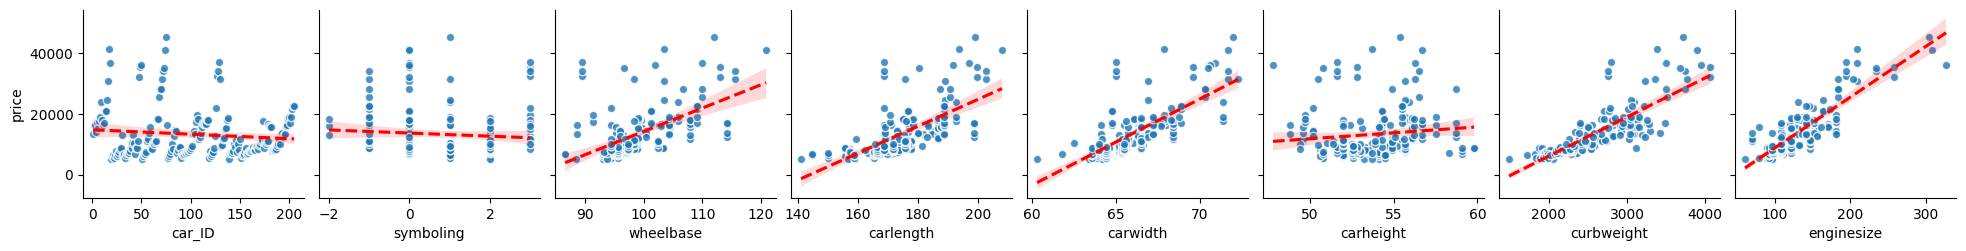

In [8]:
# Quick EDA for features related to target.
sns.pairplot(df, 
             y_vars = 'price',
             x_vars = num_cols[:8],
             kind = 'reg',
             plot_kws = plot_kws);

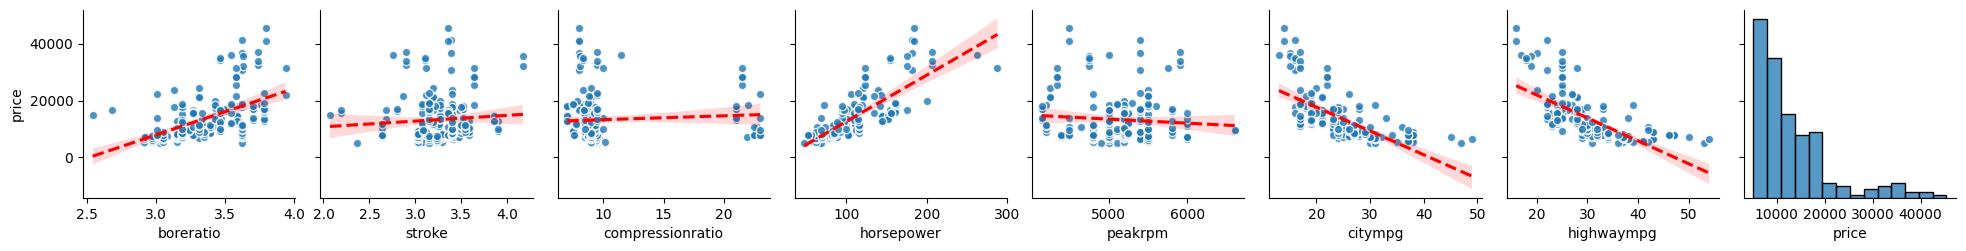

In [9]:
# Plot the rest of the pairplots
sns.pairplot(df, 
             y_vars = 'price',
             x_vars = num_cols[8:],
             kind = 'reg',
             plot_kws = plot_kws);

In [10]:
# Drop columns without a linear relationship to price
cols_to_drop = ['price',
                'car_ID',
                'symboling',
                'stroke',
                'compressionratio',
                'peakrpm']

In [11]:
# Call the info method
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

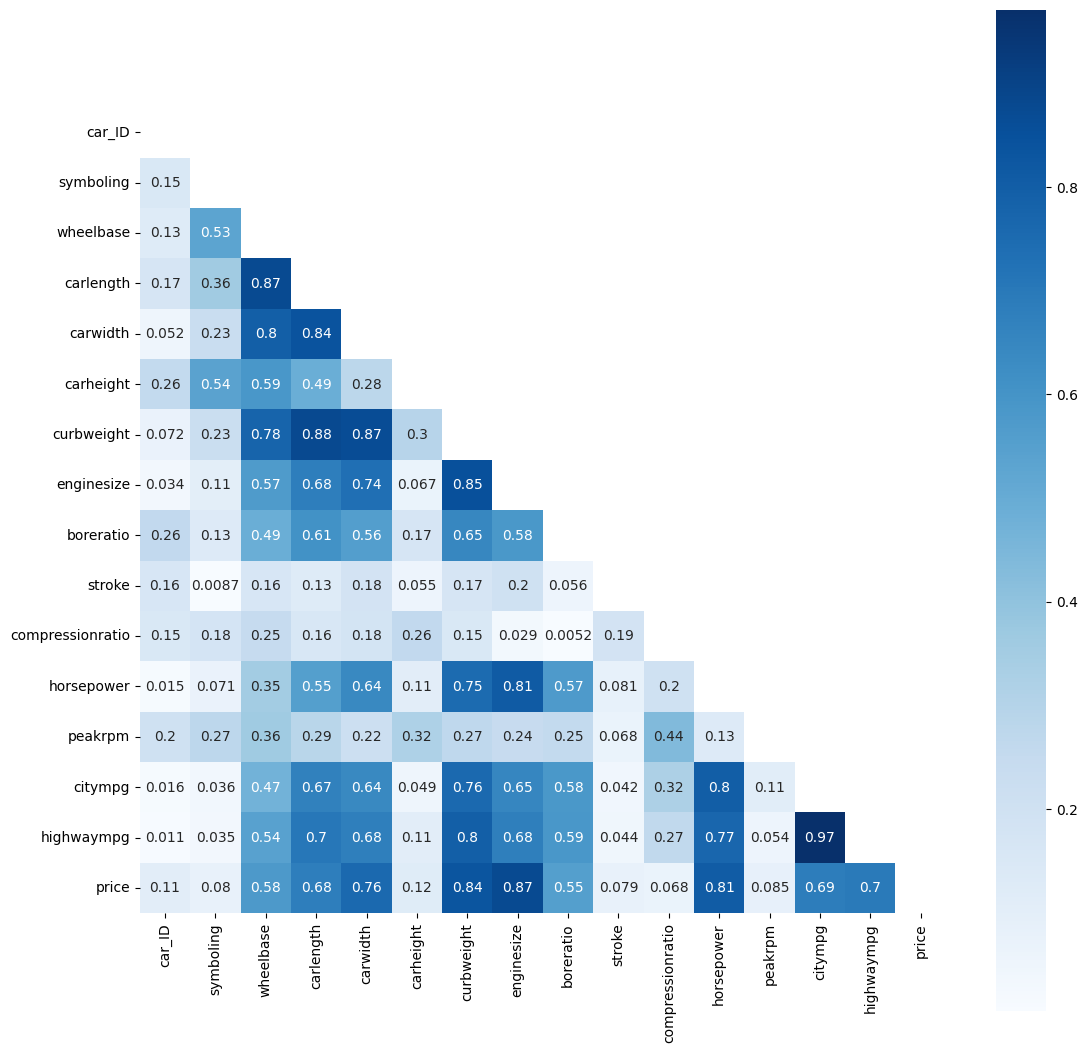

In [12]:
# Make a correlation matrix
corr = df.corr().abs()
mask = np.triu(np.ones_like(corr))
plt.figure(figsize = (13, 13));
sns.heatmap(corr, square = True, cmap = 'Blues', annot = True, mask = mask);

In [13]:
# Drop columns with multicolinearity
cols_to_drop.extend(['wheelbase',
                     'carlength',
                     'carwidth',
                     'curbweight',
                     'horsepower',
                     'highwaympg'])

In [14]:
# Set the target and features
X = df.drop(columns = cols_to_drop).copy()
y = df['price'].copy()

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [16]:
# Get the numeric and categorical columns
cat_select = make_column_selector(dtype_include = 'object')
num_select = make_column_selector(dtype_include = 'number')
cat_cols = cat_select(X_train)
num_cols = num_select(X_train)

In [17]:
# Make a preprocessing pipeline
cat_pipe = make_pipeline(OneHotEncoder(handle_unknown = 'ignore',
                         sparse = False))
num_pipe = make_pipeline(SimpleImputer(strategy = 'mean'))
preprocessor = make_column_transformer((cat_pipe, cat_cols), 
                                       (num_pipe, num_cols),
                                       remainder = 'passthrough')

In [18]:
# Fit the column transformer
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['CarName', 'fueltype', 'aspiration',
                                  'doornumber', 'carbody', 'drivewheel',
                                  'enginelocation', 'enginetype',
                                  'cylindernumber', 'fuelsystem']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['carheight', 'enginesize', 'boreratio',
                                  'citympg'])])

In [19]:
# Explore the transformation as a data frame
pd.DataFrame(preprocessor.transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,54.5,103.0,2.99,45.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,54.9,122.0,3.31,29.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,53.5,97.0,3.15,31.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,53.1,136.0,3.19,19.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,52.0,146.0,3.62,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,49.7,181.0,3.43,19.0
149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,55.7,164.0,3.31,20.0
150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,54.5,97.0,3.15,31.0
151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,52.0,171.0,3.27,19.0


In [20]:
# Make an empty list for the feature names
final_features = []

In [21]:
# Investigate the categorical pipeline
preprocessor.named_transformers_['pipeline-1'].named_steps

{'onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False)}

In [22]:
# Get the one hot encoder steps
ohe_step = preprocessor.named_transformers_['pipeline-1'].\
named_steps['onehotencoder']
ohe_step

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [23]:
# Get the feature names
cat_features = ohe_step.get_feature_names_out(cat_cols)
cat_features

array(['CarName_Nissan versa', 'CarName_alfa-romero Quadrifoglio',
       'CarName_alfa-romero giulia', 'CarName_alfa-romero stelvio',
       'CarName_audi 100 ls', 'CarName_audi 100ls', 'CarName_audi 4000',
       'CarName_audi 5000', 'CarName_audi fox', 'CarName_bmw 320i',
       'CarName_bmw x1', 'CarName_bmw x3', 'CarName_bmw z4',
       'CarName_buick opel isuzu deluxe',
       'CarName_buick regal sport coupe (turbo)', 'CarName_buick skyhawk',
       'CarName_buick skylark', 'CarName_chevrolet vega 2300',
       'CarName_dodge challenger se', 'CarName_dodge colt (sw)',
       'CarName_dodge coronet custom', 'CarName_dodge d200',
       'CarName_dodge dart custom', 'CarName_dodge rampage',
       'CarName_honda accord', 'CarName_honda accord cvcc',
       'CarName_honda accord lx', 'CarName_honda civic',
       'CarName_honda civic (auto)', 'CarName_honda civic 1500 gl',
       'CarName_honda civic cvcc', 'CarName_honda prelude',
       'CarName_isuzu D-Max ', 'CarName_isuzu MU-X'

In [24]:
# Add the categorical feature names to the final_features list
final_features.extend(cat_features)

In [25]:
# Add the numeric feature names to the final_features list
final_features.extend(num_cols)
final_features

['CarName_Nissan versa',
 'CarName_alfa-romero Quadrifoglio',
 'CarName_alfa-romero giulia',
 'CarName_alfa-romero stelvio',
 'CarName_audi 100 ls',
 'CarName_audi 100ls',
 'CarName_audi 4000',
 'CarName_audi 5000',
 'CarName_audi fox',
 'CarName_bmw 320i',
 'CarName_bmw x1',
 'CarName_bmw x3',
 'CarName_bmw z4',
 'CarName_buick opel isuzu deluxe',
 'CarName_buick regal sport coupe (turbo)',
 'CarName_buick skyhawk',
 'CarName_buick skylark',
 'CarName_chevrolet vega 2300',
 'CarName_dodge challenger se',
 'CarName_dodge colt (sw)',
 'CarName_dodge coronet custom',
 'CarName_dodge d200',
 'CarName_dodge dart custom',
 'CarName_dodge rampage',
 'CarName_honda accord',
 'CarName_honda accord cvcc',
 'CarName_honda accord lx',
 'CarName_honda civic',
 'CarName_honda civic (auto)',
 'CarName_honda civic 1500 gl',
 'CarName_honda civic cvcc',
 'CarName_honda prelude',
 'CarName_isuzu D-Max ',
 'CarName_isuzu MU-X',
 'CarName_jaguar xf',
 'CarName_jaguar xj',
 'CarName_jaguar xk',
 'CarName_

In [26]:
# Transform X_train and X_test into data frames
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns = final_features,
                          index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         columns = final_features,
                         index = X_test.index)
display(X_train_df.head(), X_test_df.head())

,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,carheight,enginesize,boreratio,citympg
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,54.5,103.0,2.99,45.0
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,54.9,122.0,3.31,29.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,53.5,97.0,3.15,31.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,53.1,136.0,3.19,19.0
167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,52.0,146.0,3.62,24.0


,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,carheight,enginesize,boreratio,citympg
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,55.7,209.0,3.62,16.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,52.0,131.0,3.13,16.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,54.7,120.0,3.33,27.0
132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,56.1,121.0,3.54,21.0
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,58.7,183.0,3.58,22.0


In [27]:
# Add a constant column to X_train_df and X_test_df
X_train_df = sm.add_constant(X_train_df, has_constant = 'add', prepend = False)
X_test_df = sm.add_constant(X_test_df, has_constant = 'add', prepend = False)

display(X_train_df.head(), X_test_df.head())

,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,carheight,enginesize,boreratio,citympg,const
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,54.5,103.0,2.99,45.0,1.0
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,54.9,122.0,3.31,29.0,1.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,53.5,97.0,3.15,31.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,53.1,136.0,3.19,19.0,1.0
167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,52.0,146.0,3.62,24.0,1.0


,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,carheight,enginesize,boreratio,citympg,const
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,55.7,209.0,3.62,16.0,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,52.0,131.0,3.13,16.0,1.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,54.7,120.0,3.33,27.0,1.0
132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,56.1,121.0,3.54,21.0,1.0
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,58.7,183.0,3.58,22.0,1.0


In [28]:
# Construct a linear regression model
model = sm.OLS(y_train, X_train_df, hasconst = True)
result = model.fit()

In [29]:
# Evaluate the model
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     13.40
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           3.31e-07
Time:                        18:51:09   Log-Likelihood:                -1226.9
No. Observations:                 153   AIC:                             2728.
Df Residuals:                      16   BIC:                             3143.
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
CarName_Nissan versa                    -2618.8941   2712.488     -0.965      0.349   -8369.112    3131.324
CarName_alfa-romero Quadrifoglio         6133.3450   3624.312      1.692      0.110   -1549.853    1.38e+04
CarName_alfa-romero giulia              -3066.7546   3715.084     -0.825      0.421   -1.09e+04    4808.872
CarName_alfa-romero stelvio               -61.7546   3715.084     -0.017      0.987   -7937.381    7813.872
CarName_audi 100 ls                      1371.3242   2609.068      0.526      0.606   -4159.653    6902.302
CarName_audi 100ls                      -2617.6745   2277.809     -1.149      0.267   -7446.413    2211.064
CarName_audi 4000                        3578.0014   3008.808      1.189      0.252   -2800.387    9956.390
CarName_audi 5000                       -1605.3709   2776.498     -0.578      0.571   -7491.283    4280.542
CarName_audi fox                        -5623.1925   3049.161     -1.844      0.084   -1.21e+04     840.739
CarName_bmw 320i                         1.134e+04   3746.880      3.028      0.008    3401.768    1.93e+04
CarName_bmw x1                           8605.7960   4984.863      1.726      0.104   -1961.642    1.92e+04
CarName_bmw x3                           1.147e+04   4548.458      2.522      0.023    1829.040    2.11e+04
CarName_bmw z4                            1.21e+04   5117.575      2.364      0.031    1246.976    2.29e+04
CarName_buick opel isuzu deluxe          2381.5623   3618.863      0.658      0.520   -5290.085    1.01e+04
CarName_buick regal sport coupe (turbo)   112.9718   2986.114      0.038      0.970   -6217.306    6443.250
CarName_buick skyhawk                    1.124e+04   4214.469      2.667      0.017    2307.230    2.02e+04
CarName_buick skylark                     268.2257   1981.702      0.135      0.894   -3932.796    4469.247
CarName_chevrolet vega 2300              -654.7864   3496.103     -0.187      0.854   -8066.193    6756.620
CarName_dodge challenger se             -1798.9221   3278.196     -0.549      0.591   -8748.387    5150.543
CarName_dodge colt (sw)                 -1607.5378   3216.445     -0.500      0.624   -8426.097    5211.021
CarName_dodge coronet custom            -3704.2920   4068.350     -0.911      0.376   -1.23e+04    4920.225
CarName_dodge d200                      -3752.8753   3755.552     -0.999      0.333   -1.17e+04    4208.539
CarName_dodge dart custom               -3976.9282   4053.147     -0.981      0.341   -1.26e+04    4615.359
CarName_dodge rampage                   -1563.1437   3895.074     -0.401      0.693   -9820.331    6694.044
CarName_honda accord                    -4507.4117   5165.099     -0.873      0.396   -1.55e+04    6442.109
CarName_honda accord cvcc               -3290.4464   4835.4

In [30]:
# Evaluate the model on the test set
test_preds = result.predict(X_test_df)
print('Test r2:', r2_score(y_test, test_preds))
print('Test MSE:', mean_squared_error(y_test, test_preds))

Test r2: 0.5849193893625907
Test MSE: 28084161.884196058


# Diagnosing the Model

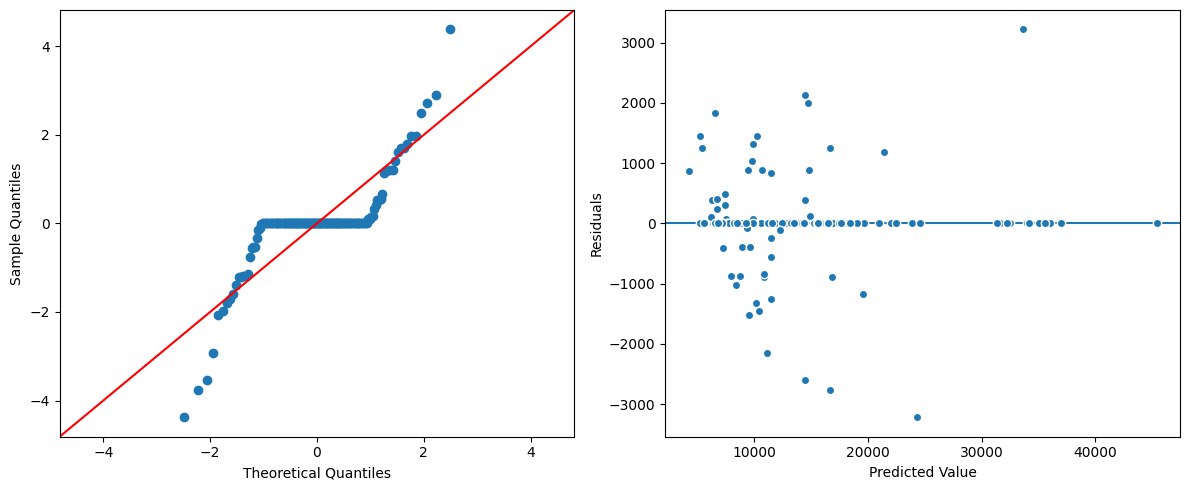

In [31]:
# Evaluate the model
evaluate_ols(result, X_train_df, y_train)

In [32]:
# Get the z-scores of the target
scaler = StandardScaler()
z_price = scaler.fit_transform(y_train.values.reshape(-1, 1))
z_price = pd.Series(z_price.flatten(), index = y_train.index)

In [33]:
# Find any outliers
idx_outliers = z_price > 3
idx_outliers.sum()

2

In [34]:
# Remove the outliers
X_train_cln = X_train_df[~idx_outliers]
y_train_cln = y_train[~idx_outliers]

In [35]:
# Determine the range our model is valid for
print('Min:', y_train_cln.min())
print('Max:', y_train_cln.max())

Min: 5118.0
Max: 36880.0


In [36]:
# Remove outliers from the test data
z_price_test = scaler.transform(y_test.values.reshape(-1, 1))
z_price_test = pd.Series(z_price_test.flatten(), index = y_test.index)
idx_outliers_test = z_price_test > 3
print(idx_outliers_test.sum())
X_test_cln = X_test_df[~idx_outliers_test]
y_test_cln = y_test[~idx_outliers_test]

2


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     11.28
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           1.18e-06
Time:                        18:51:10   Log-Likelihood:                -1211.8
No. Observations:                 151   AIC:                             2694.
Df Residuals:                      16   BIC:                             3101.
Df Model:                         134                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

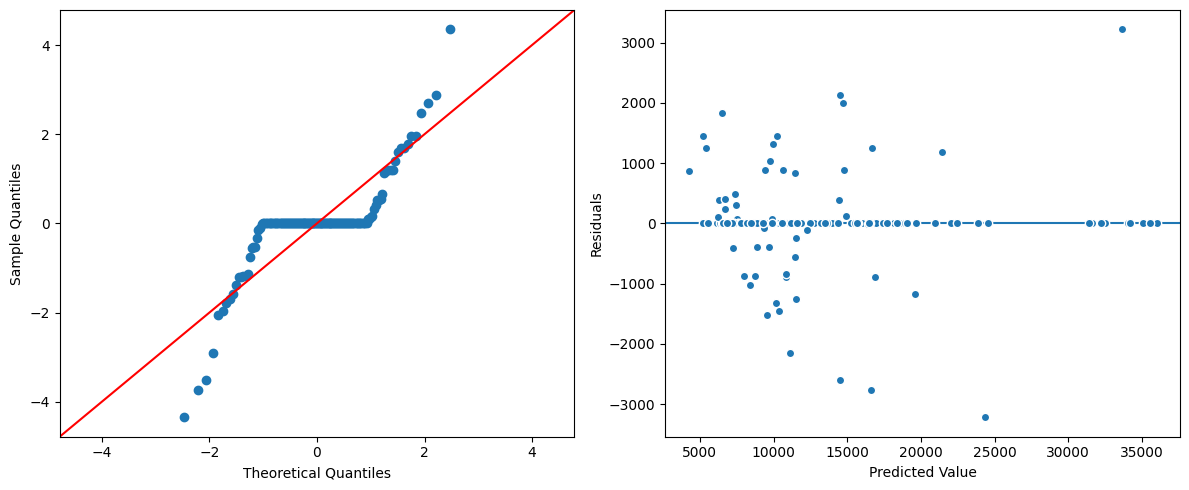

In [37]:
# Construct a model with the outliers removed
model = sm.OLS(y_train_cln, X_train_cln)
result = model.fit()
print(result.summary())
evaluate_ols(result, X_train_cln, y_train_cln)

In [38]:
# Investigate the p-values
p_vals = result.pvalues
p_vals[p_vals > 0.05]

CarName_Nissan versa                0.347808
CarName_alfa-romero Quadrifoglio    0.108649
CarName_alfa-romero giulia          0.490189
CarName_alfa-romero stelvio         0.876552
CarName_audi 100 ls                 0.607074
                                      ...   
fuelsystem_spfi                     0.787335
carheight                           0.523105
boreratio                           0.304231
citympg                             0.526182
const                               0.410640
Length: 146, dtype: float64

In [39]:
# Determine the number of insignificant p-values
(p_vals > 0.05).sum()

146

In [40]:
# Determine how many carName columns have insignificant p-values
print(p_vals[p_vals > 0.05].index.str.startswith('CarName').sum())
print(p_vals.index.str.startswith('CarName').sum())

109
119


In [42]:
# Determine the features with insignificant p-values not starting with CarName
filter = p_vals.index.str.startswith('CarName')
p_vals[~filter]

fueltype_diesel          0.682504
fueltype_gas             0.295554
aspiration_std           0.479479
aspiration_turbo         0.372396
doornumber_four          0.380542
doornumber_two           0.456238
carbody_convertible      0.306383
carbody_hardtop          0.745392
carbody_hatchback        0.637200
carbody_sedan            0.518915
carbody_wagon            0.502321
drivewheel_4wd           0.357129
drivewheel_fwd           0.264468
drivewheel_rwd           0.636300
enginelocation_front     0.742840
enginelocation_rear      0.016232
enginetype_dohc          0.552591
enginetype_dohcv         0.810826
enginetype_l             0.433908
enginetype_ohc           0.634283
enginetype_ohcf          0.886338
enginetype_ohcv          0.267780
enginetype_rotor         0.013405
cylindernumber_eight     0.250610
cylindernumber_five      0.132705
cylindernumber_four      0.417133
cylindernumber_six       0.384009
cylindernumber_twelve    0.070571
cylindernumber_two       0.013405
fuelsystem_1bb

In [ ]:
# Call df.info to determine which features to drop
df.info()

In [ ]:
# All the above can be removed from the data
X_train_cln.drop(columns = p_vals[p_vals > 0.05].index)